# Exploring the Impact of Weather and Climate on Bicycle Traffic in Köln: A Comprehensive Report

This project aims to analyze **the weather and climate conditions of Köln and its bicycle traffic** generated from several automatic counting stations throughout the city to determine if Köln is a suitable city for an enthusiastic cyclist to live in. The project is using two open data sources: [mobilithek](https://mobilithek.info/), which contains information on bicycle traffic in Köln, and [meteostat](https://meteostat.net/en/), which provides weather and climate data of Köln.

### Datasource1: Bicycle Traffic Data in Köln
* Source: [mobilithek](https://mobilithek.info/)
* Metadata URL: [https://mobilithek.info/offers/-2236641647976866002](https://mobilithek.info/offers/-2236641647976866002)
* Sample Data URL: [https://offenedaten-koeln.de/sites/default/files/Fahrrad_Zaehlstellen_Koeln_2016.csv](https://offenedaten-koeln.de/sites/default/files/Fahrrad_Zaehlstellen_Koeln_2016.csv)
* Data Type: CSV

This data source contains Köln's bicycle traffic generated from several [automatic counting stations](http://www.eco-public.com/ParcPublic/?id=677) throughout the city from 2009.

### Datasource2: Weather and Climate Data of Köln
* Source: [meteostat](https://meteostat.net/en/)
* Metadata URL: [https://dev.meteostat.net/bulk/monthly.html](https://dev.meteostat.net/bulk/monthly.html)
* Sample Data URL: [https://bulk.meteostat.net/v2/monthly/{station}.csv.gz](https://bulk.meteostat.net/v2/monthly/{station}.csv.gz), Station-id of Köln = '10513', 'D2968'
* Data Type: CSV

This data source will provide weather and climate data in Köln, including average air temperature, daily minimum and maximum air temperature, monthly precipitation total, maximum snow depth, average wind direction and speed, peak wind gust, average sea-level air pressure, and monthly sunshine total.

Now, the question that interests us is: **How do the weather conditions in Köln impact bicycle traffic throughout the year?**

### Project Structure: ETL Pipeline

The project follows a structured ETL (Extract, Transform, Load) pipeline approach, encompassing various directories and modules with specific functionalities. The `main.py` serves as the entry point for running the pipeline using the command `pdm run main.py`, resulting in the generation of the final dataset stored in an SQLite database.

```bash
project/
├── config/                     # Configuration files and settings
│   ├── __init__.py
│   ├── config_var.py           # Configuration variables
│   └── source_info.json        # Source information
├── data/                       # Data directory
│   ├── processed/              # Processed data
│   └── raw/                    # Raw data
├── etl/                        # ETL (Extract, Transform, Load) pipeline modules
│   ├── __init__.py
│   ├── extract/                # Extraction module
│   │   ├── __init__.py
│   │   └── data_extractor.py   # Data extraction logic
│   ├──transform/               # Transformation module
│   │   ├── __init__.py
│   │   └── data_transformer.py # Data transformation logic
│   └── load/                   # Loading module
│       ├── __init__.py
│       └── data_loader.py      # Data loading logic
├── pipelines/                  # Data pipeline modules
│   ├── __init__.py
│   └── data_pipeline.py        # ETL data pipeline implementation
├── utils/                      # Utility modules
│   ├── __init__.py
│   └── service_factory.py      # Service factory utility
├── tests/                      # Test modules
│   ├── __init__.py
│   ├── test_component.py       # Test cases for component testing
│   ├── test_pipeline.py        # Test cases for system testing
│   └── transformed_data.pkl    # Original transformed data for testing purposes
├── main.py                     # Entry point of the project
├── tests.sh                    # Bash script for running all the test cases
├── exploration.ipynb           # Notebook for data exploration
├── report.ipynb                # Notebook for final project report
└── project-plan.md             # Project plan and documentation
```

### Install Dependencies

To install the dependencies for this project, we will be using [PDM](https://pdm.fming.dev/latest/), which is a modern Python package and dependency manager supporting the latest PEP standards. To install the dependencies using PDM, follow these steps:
- Install PDM on the system. We can install it by following the instructions provided in the [PDM documentation](https://pdm.fming.dev/latest/#installation).
- Once PDM is installed, navigate to the project directory in terminal and run the following command to install the dependencies specified in the `pyproject.toml` file:
    ```bash
    pdm install
    ```

In [42]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scipy

Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Import Packages

In [43]:
import sqlite3
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

### Load Data

This section involves retrieving the data from a sqlite database and loading it into two Pandas DataFrames. And then merge these together for creating comprehensive report.

In [44]:
conn = sqlite3.connect("fau_data_engineering_ss23.sqlite")
bicycle_traffic_df = pd.read_sql_query(f"SELECT * FROM mobilithek_bicycle_traffic", conn)
weather_data_df = pd.read_sql_query(f"SELECT * FROM meteostat_weather_data", conn)
conn.close()

In [45]:
bicycle_traffic_df.head()

,Date,Deutzer Brücke,Hohenzollernbrücke,Neumarkt,Zülpicher Straße,Bonner Straße,Venloer Straße,A.-Schütte-Allee,Vorgebirgspark,A.-Silbermann-Weg,Stadtwald,Niederländer Ufer,Vorgebirgswall,Universitäts-straße,Rodenkirchener Brücke,Severinsbrücke,Neusser Straße,Hohe Pforte
0,January-2009,46319,24610,59344,78727,0,0,0,0,0,0,0,0,0,0,0,0,0
1,February-2009,47764,29590,62228,91075,0,0,0,0,0,0,0,0,0,0,0,0,0
2,March-2009,68778,44312,84760,107262,0,0,0,0,0,0,0,0,0,0,0,0,0
3,April-2009,78619,55086,95298,146057,0,0,0,0,0,0,0,0,0,0,0,0,0
4,May-2009,79369,52725,102051,159319,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
# Convert None to NaN in weather_data_df
weather_data_df = weather_data_df.where(pd.notnull(weather_data_df), np.nan)
# Convert dtype of tsun_D2968 column from object to float
weather_data_df["tsun_D2968"] = weather_data_df["tsun_D2968"].astype(float)
weather_data_df.head()

,date,tavg_10513,tmin_10513,tmax_10513,prcp_10513,wspd_10513,pres_10513,tsun_10513,tavg_D2968,tmin_D2968,tmax_D2968,prcp_D2968,wspd_D2968,pres_D2968,tsun_D2968
0,January-2009,-0.5,-4.4,2.9,26.0,11.1,1015.2,5340.0,0.4,-2.6,3.4,36.9,NaN,NaN,NaN
1,February-2009,3.1,0.0,6.2,70.0,12.3,1014.5,1800.0,3.8,1.2,6.4,71.0,NaN,NaN,NaN
2,March-2009,6.1,1.7,10.5,104.0,12.6,1014.9,5460.0,6.9,3.3,10.6,100.0,NaN,NaN,NaN
3,April-2009,13.3,6.8,19.1,78.0,10.0,1014.0,11220.0,14.0,8.8,19.0,59.2,NaN,NaN,NaN
4,May-2009,14.5,8.0,20.1,63.0,10.8,1019.2,11940.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Exploration

This section focuses on exploring two sets of data further: [Mobilithek Bicycle Traffic Data in Köln](https://mobilithek.info/offers/-2236641647976866002) and [Meteostat Weather and Climate Data of Köln](https://dev.meteostat.net/bulk/monthly.html).

#### Exploration of the Mobilithek Bicycle Traffic Data in Köln

In [47]:
bicycle_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Date                   168 non-null    object
 1   Deutzer Brücke         168 non-null    int64 
 2   Hohenzollernbrücke     168 non-null    int64 
 3   Neumarkt               168 non-null    int64 
 4   Zülpicher Straße       168 non-null    int64 
 5   Bonner Straße          168 non-null    int64 
 6   Venloer Straße         168 non-null    int64 
 7   A.-Schütte-Allee       168 non-null    int64 
 8   Vorgebirgspark         168 non-null    int64 
 9   A.-Silbermann-Weg      168 non-null    int64 
 10  Stadtwald              168 non-null    int64 
 11  Niederländer Ufer      168 non-null    int64 
 12  Vorgebirgswall         168 non-null    int64 
 13  Universitäts-straße    168 non-null    int64 
 14  Rodenkirchener Brücke  168 non-null    int64 
 15  Severinsbrücke         

Now, let's examine the date range of the 'Bicycle Traffic Data in Köln' to determine the available data period, starting from the minimum date and ending at the maximum date.

In [48]:
date_df = pd.to_datetime(bicycle_traffic_df['Date'], format='%B-%Y')
min_date = date_df.min().strftime('%B-%Y')
max_date = date_df.max().strftime('%B-%Y')
f"Date Range of the Bicycle Traffic Data in Köln: {min_date} to {max_date}"

'Date Range of the Bicycle Traffic Data in Köln: January-2009 to December-2022'

In [49]:
bicycle_traffic_df.head(6)

,Date,Deutzer Brücke,Hohenzollernbrücke,Neumarkt,Zülpicher Straße,Bonner Straße,Venloer Straße,A.-Schütte-Allee,Vorgebirgspark,A.-Silbermann-Weg,Stadtwald,Niederländer Ufer,Vorgebirgswall,Universitäts-straße,Rodenkirchener Brücke,Severinsbrücke,Neusser Straße,Hohe Pforte
0,January-2009,46319,24610,59344,78727,0,0,0,0,0,0,0,0,0,0,0,0,0
1,February-2009,47764,29590,62228,91075,0,0,0,0,0,0,0,0,0,0,0,0,0
2,March-2009,68778,44312,84760,107262,0,0,0,0,0,0,0,0,0,0,0,0,0
3,April-2009,78619,55086,95298,146057,0,0,0,0,0,0,0,0,0,0,0,0,0
4,May-2009,79369,52725,102051,159319,0,0,0,0,0,0,0,0,0,0,0,0,0
5,June-2009,85576,51538,131255,160123,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
bicycle_traffic_df.tail(6)

,Date,Deutzer Brücke,Hohenzollernbrücke,Neumarkt,Zülpicher Straße,Bonner Straße,Venloer Straße,A.-Schütte-Allee,Vorgebirgspark,A.-Silbermann-Weg,Stadtwald,Niederländer Ufer,Vorgebirgswall,Universitäts-straße,Rodenkirchener Brücke,Severinsbrücke,Neusser Straße,Hohe Pforte
162,July-2022,160142,78793,144518,155971,83698,181380,82110,35634,94880,82634,92596,89681,90651,69970,50351,104689,95068
163,August-2022,199040,104883,161798,174193,99881,207493,98258,45461,113437,116920,113372,124947,99332,84308,65845,128545,112127
164,September-2022,159829,79025,137943,163504,85979,178292,69677,34505,84756,78143,77222,100410,100228,55764,54330,105910,95742
165,October-2022,152882,75197,136711,172506,85703,189374,68128,31347,90212,75335,73277,96018,176722,51947,52062,104598,94887
166,November-2022,135685,69464,122413,162549,77491,169261,48256,28750,75998,65878,57586,93465,176539,41001,47036,99518,93621
167,December-2022,84232,43723,90147,105479,59919,121938,26591,18024,47965,32779,31445,62247,111549,20481,27754,70152,75571


By examining the head and tail of the Mobilithek Bicycle Traffic Data in Köln, we can observe that initially not all counting stations recorded bicycle traffic counts. Hence, we can verify the number of counting stations based on the date.

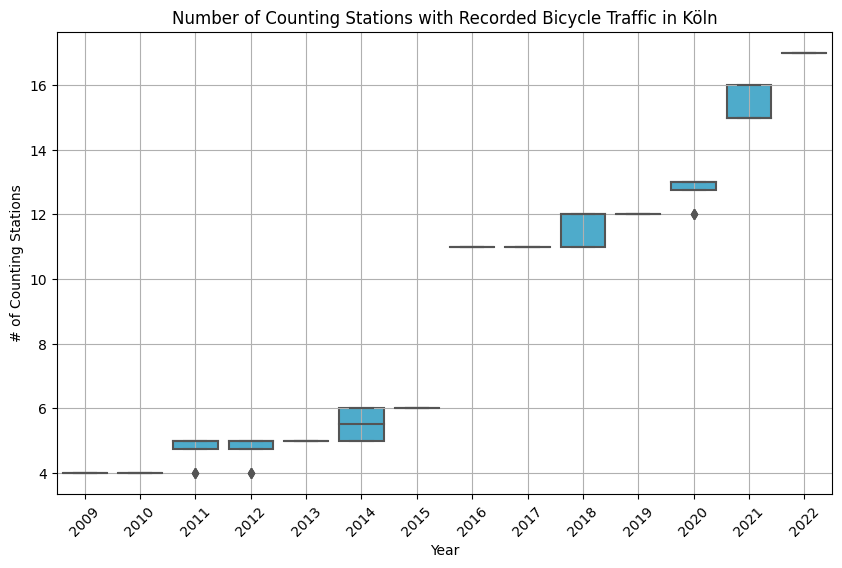

In [51]:
# Calculate the stations count for each year
counting_stations_df = pd.DataFrame({'Date': bicycle_traffic_df['Date']})
counting_stations_df['Counting Stations'] = (bicycle_traffic_df.iloc[:, 1:] != 0).sum(axis=1)

# Extract the year from the date column
counting_stations_df['Year'] = counting_stations_df['Date'].str.split('-').str[1]

plt.figure(figsize=(10, 6))  # Set the figure size
sns.boxplot(data=counting_stations_df, x='Year', y='Counting Stations', color='#39B5E0')  # Create the box plot

# Customize the plot
plt.title('Number of Counting Stations with Recorded Bicycle Traffic in Köln')
plt.xlabel('Year')
plt.ylabel('# of Counting Stations')
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

Among the 17 counting stations from 2009 to 2022, the number of stations that started counting Bicycle Traffic from the beginning varies. To analyze this, we can examine the stacked bar chart showing the zero count and non-zero count for each station. The chart provides insights into which stations have consistently recorded Bicycle Traffic data since the beginning, as well as stations that started counting at a later time. This information helps us understand the availability and reliability of historical data across different stations.

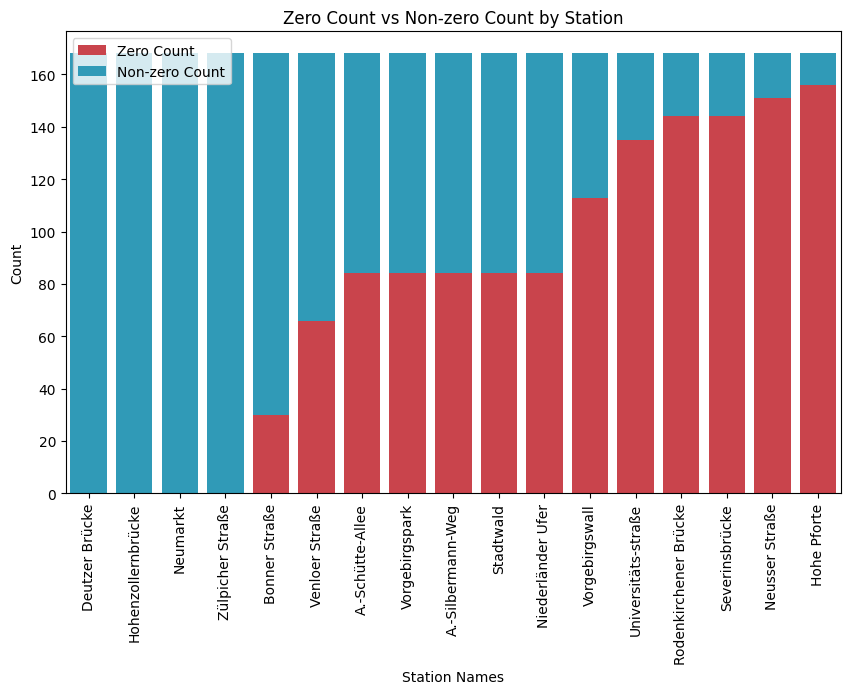

In [52]:
station_names = bicycle_traffic_df.columns[1:]
result_df = pd.DataFrame(columns=['station name', 'zero count', 'non zero count'])

for station_name in station_names:
    zero_count = (bicycle_traffic_df[station_name] == 0).sum()
    non_zero_count = (bicycle_traffic_df[station_name] != 0).sum()
    result_df.loc[len(result_df)] = [station_name, zero_count, non_zero_count]

# Create and customize the stacked bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(data=result_df, x='station name', y='zero count', color='#DF2E38', label='Zero Count')
sns.barplot(data=result_df, x='station name', y='non zero count', color='#19A7CE', bottom=result_df['zero count'], label='Non-zero Count')

# Customize the chart labels and title
plt.title('Zero Count vs Non-zero Count by Station')
plt.xlabel('Station Names')
plt.ylabel('Count')
# plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.legend(loc="upper left")
plt.xticks(rotation=90)

plt.show()

#### Exploration of the Meteostat Weather and Climate Data of Köln

Station Details of Köln:
- Station ID: 10513, Station Name: Köln-Bonn Airport, Station Region: NW
- Station ID: D2968, Station Name: Köln-Stammheim, Station Region: NW

In [53]:
weather_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        168 non-null    object 
 1   tavg_10513  168 non-null    float64
 2   tmin_10513  168 non-null    float64
 3   tmax_10513  168 non-null    float64
 4   prcp_10513  168 non-null    float64
 5   wspd_10513  168 non-null    float64
 6   pres_10513  168 non-null    float64
 7   tsun_10513  168 non-null    float64
 8   tavg_D2968  166 non-null    float64
 9   tmin_D2968  166 non-null    float64
 10  tmax_D2968  166 non-null    float64
 11  prcp_D2968  164 non-null    float64
 12  wspd_D2968  21 non-null     float64
 13  pres_D2968  21 non-null     float64
 14  tsun_D2968  0 non-null      float64
dtypes: float64(14), object(1)
memory usage: 19.8+ KB


Now, let's examine the date range of the 'Weather and Climate Data of Köln' to determine the available data period, starting from the minimum date and ending at the maximum date.

In [54]:
date_df = pd.to_datetime(weather_data_df['date'], format='%B-%Y')
min_date = date_df.min().strftime('%B-%Y')
max_date = date_df.max().strftime('%B-%Y')
f"Date Range of the Weather and Climate Data of Köln: {min_date} to {max_date}"

'Date Range of the Weather and Climate Data of Köln: January-2009 to December-2022'

Now, examining the 'Weather and Climate Data of Köln', it is apparent that the dataset contains a significant number of `null` values. Visualizing these `null` values allows us to assess their severity and identify columns that should be excluded from our reports.

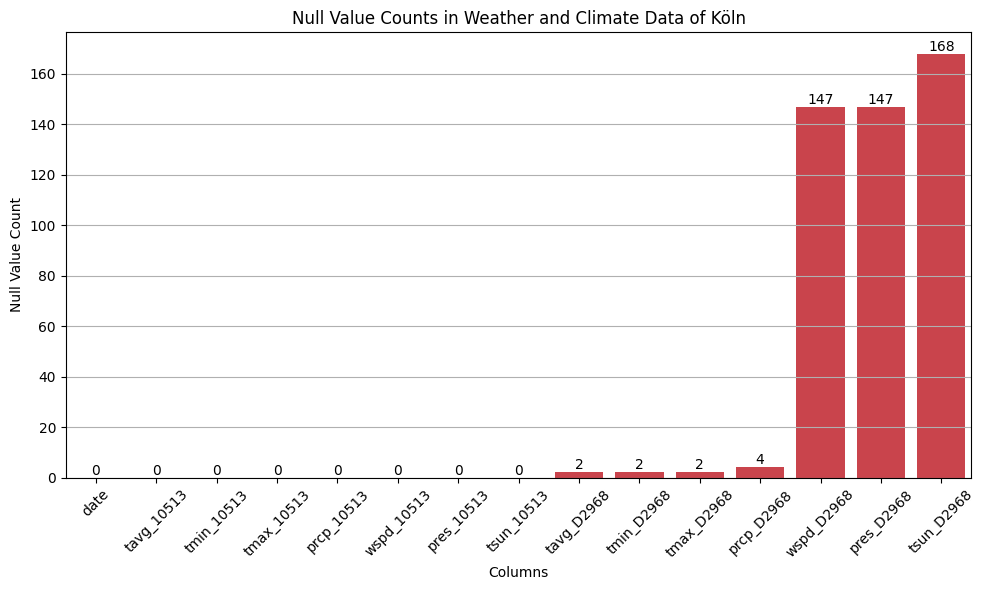

In [55]:
# Count the number of null values in each column
null_counts = weather_data_df.isnull().sum()

# Create a bar plot of null value counts
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=null_counts.index, y=null_counts, color='#DF2E38')

plt.title('Null Value Counts in Weather and Climate Data of Köln')
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Add text annotations for null count above each bar
for i, count in enumerate(null_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Exploration Summary

**Bicycle Traffic Data in Köln**
* Stations count: Total 17 stations
* Data available: January-2009 to December-2022
* No of rows: 168 (14 years * 12 = 168)
* Remarks:
    - Number of stations that started counting Bicycle Traffic from the beginning varies a lot
    - Only 4 stations (Deutzer Brücke, Hohenzollernbrücke, Neumarkt, Zülpicher Straße) has started counting Bicycle Traffic from 2009

**Weather and Climate Data of Köln**
* Station details of Köln: Köln-Bonn Airport (10513), Köln-Stammheim (D2968)
* Data available: January-2009 to December-2022
* No of rows: 168 (14 years * 12 = 168)
* Remarks: wspd (average wind speed), pres (average sea-level air pressure), and tsun (monthly sunshine total) of station Köln-Stammheim (D2968) has high number of null count

### Combining Data Sources

Based on the previous data exploration, it is evident that only four stations (Deutzer Brücke, Hohenzollernbrücke, Neumarkt, Zülpicher Straße) have been consistently recording bicycle traffic since 2009. To analyze the overall bicycle traffic in Köln, we will focus on these specific columns and calculate the sum of their traffic values. The resulting column, 'Total Traffic', will represent the aggregated bicycle traffic for the city of Köln.

In [56]:
# Select the desired stations from the bicycle_traffic_df
col_sub_set = ["Date", "Deutzer Brücke", "Hohenzollernbrücke", "Neumarkt", "Zülpicher Straße"]
bicycle_traffic_final_df = bicycle_traffic_df[col_sub_set].copy()

# Calculate the total traffic by summing the values of the selected stations
bicycle_traffic_final_df['total_traffic'] = bicycle_traffic_final_df[col_sub_set[1:]].sum(axis=1)

# Rename desired columns and drop the individual station traffic columns, keeping only the 'date' and 'total_traffic' columns
bicycle_traffic_final_df.rename(columns={'Date': 'date'}, inplace=True)
bicycle_traffic_final_df.drop(col_sub_set[1:], axis=1, inplace=True)

bicycle_traffic_final_df

,date,total_traffic
0,January-2009,209000
1,February-2009,230657
2,March-2009,305112
3,April-2009,375060
4,May-2009,393464
...,...,...
163,August-2022,639914
164,September-2022,540301
165,October-2022,537296
166,November-2022,490111


Based on the previous data exploration, we need to make the following changes in the weather data for Köln city:
- Drop the columns with a high null count for station D2968: 'wspd_D2968', 'pres_D2968', 'tsun_D2968'. These columns have a significant number of missing values and are not suitable for analysis.
- Fill in the missing values for the remaining columns with a few null counts. This can be done using methods like linear interpolation, which estimates the missing values based on nearby values.
- Calculate the aggregated values for tavg, tmin, tmax, and prcp to represent the combined values for Köln city. This involves taking the average of the corresponding columns from the two stations, 'tavg_10513' and 'tavg_D2968', 'tmin_10513' and 'tmin_D2968', 'tmax_10513' and 'tmax_D2968', 'prcp_10513' and 'prcp_D2968', respectively.
- Consider the column 'wspd_10513' as the combined 'wspd' (average wind speed) for Köln city. Similarly, 'pres_10513' represents the combined 'pres' (average sea-level air pressure), and 'tsun_10513' represents the combined 'tsun' (monthly sunshine total) for Köln city.

In [57]:
# Create a copy of the weather_data_df DataFrame and drop the columns with high null count for station D2968
weather_data_final_df = weather_data_df.copy()
weather_data_final_df.drop(['wspd_D2968', 'pres_D2968', 'tsun_D2968'], axis=1, inplace=True)

# Perform linear interpolation to fill missing values using nearby values
weather_data_final_df.interpolate(method ='linear', limit_direction ='forward', inplace=True)

# Calculate the mean of tavg, tmin, tmax, and prcp columns for the two stations and drop individual columns
weather_data_final_df['tavg'] = weather_data_final_df[['tavg_10513', 'tavg_D2968']].mean(axis=1)
weather_data_final_df.drop(['tavg_10513', 'tavg_D2968'], axis=1, inplace=True)

weather_data_final_df['tmin'] = weather_data_final_df[['tmin_10513', 'tmin_D2968']].mean(axis=1)
weather_data_final_df.drop(['tmin_10513', 'tmin_D2968'], axis=1, inplace=True)

weather_data_final_df['tmax'] = weather_data_final_df[['tmax_10513', 'tmax_D2968']].mean(axis=1)
weather_data_final_df.drop(['tmax_10513', 'tmax_D2968'], axis=1, inplace=True)

weather_data_final_df['prcp'] = weather_data_final_df[['prcp_10513', 'prcp_D2968']].mean(axis=1)
weather_data_final_df.drop(['prcp_10513', 'prcp_D2968'], axis=1, inplace=True)

# Rename columns to match the desired column names and rearrange the columns in the desired order
weather_data_final_df.rename(columns={'wspd_10513': 'wspd', 'pres_10513': 'pres', 'tsun_10513': 'tsun'}, inplace=True)
weather_data_final_df = weather_data_final_df[['date', 'tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'tsun']]

weather_data_final_df

,date,tavg,tmin,tmax,prcp,wspd,pres,tsun
0,January-2009,-0.05,-3.50,3.15,31.450,11.1,1015.2,5340.0
1,February-2009,3.45,0.60,6.30,70.500,12.3,1014.5,1800.0
2,March-2009,6.50,2.50,10.55,102.000,12.6,1014.9,5460.0
3,April-2009,13.65,7.80,19.05,68.600,10.0,1014.0,11220.0
4,May-2009,15.00,9.30,20.25,57.175,10.8,1019.2,11940.0
...,...,...,...,...,...,...,...,...
163,August-2022,22.10,14.75,28.80,16.100,9.8,1016.1,16771.0
164,September-2022,15.35,10.85,20.45,130.950,10.6,1012.3,9393.0
165,October-2022,14.05,9.50,18.85,32.700,11.0,1017.9,7416.0
166,November-2022,9.30,6.30,12.45,65.900,13.2,1012.5,4865.0


Now, let's combine the modified bicycle traffic data and weather data into a single dataframe, which will represent the data for Köln city. The combined dataframe will contain the following columns:

- date: the date in the month-year format.
- tavg: the average air temperature in °C.
- tmin: the average daily minimum air temperature in °C.
- tmax: the average daily maximum air temperature in °C.
- prcp: the monthly precipitation total in mm.
- wspd: the average wind speed in km/h.
- pres: the average sea-level air pressure in hPa.
- tsun: the monthly sunshine total in minutes (m).
- total_traffic: the total bicycle traffic of the 4 stations (Deutzer Brücke, Hohenzollernbrücke, Neumarkt, Zülpicher Straße) for Köln city.

In [58]:
final_combined_df = pd.merge(weather_data_final_df, bicycle_traffic_final_df, on='date')
final_combined_df

,date,tavg,tmin,tmax,prcp,wspd,pres,tsun,total_traffic
0,January-2009,-0.05,-3.50,3.15,31.450,11.1,1015.2,5340.0,209000
1,February-2009,3.45,0.60,6.30,70.500,12.3,1014.5,1800.0,230657
2,March-2009,6.50,2.50,10.55,102.000,12.6,1014.9,5460.0,305112
3,April-2009,13.65,7.80,19.05,68.600,10.0,1014.0,11220.0,375060
4,May-2009,15.00,9.30,20.25,57.175,10.8,1019.2,11940.0,393464
...,...,...,...,...,...,...,...,...,...
163,August-2022,22.10,14.75,28.80,16.100,9.8,1016.1,16771.0,639914
164,September-2022,15.35,10.85,20.45,130.950,10.6,1012.3,9393.0,540301
165,October-2022,14.05,9.50,18.85,32.700,11.0,1017.9,7416.0,537296
166,November-2022,9.30,6.30,12.45,65.900,13.2,1012.5,4865.0,490111


### Exploratory Data Analysis (EDA)

In [59]:
final_combined_df.describe()

,tavg,tmin,tmax,prcp,wspd,pres,tsun,total_traffic
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,11.464286,6.956994,15.941964,62.984970,11.520833,1015.980952,8100.952381,431626.642857
std,6.029993,5.051886,7.191065,35.784608,1.714777,4.128417,4533.585037,128822.055010
min,-1.200000,-3.900000,0.800000,4.900000,8.000000,1004.000000,552.000000,65442.000000
25%,6.237500,2.887500,9.300000,38.725000,10.400000,1013.875000,4305.000000,328848.500000
50%,11.525000,6.700000,16.175000,56.925000,11.200000,1016.000000,8145.000000,449497.500000
75%,16.737500,11.262500,22.250000,77.937500,12.425000,1018.125000,11550.000000,530818.750000
max,22.400000,16.150000,29.400000,209.750000,19.700000,1029.200000,18600.000000,673559.000000


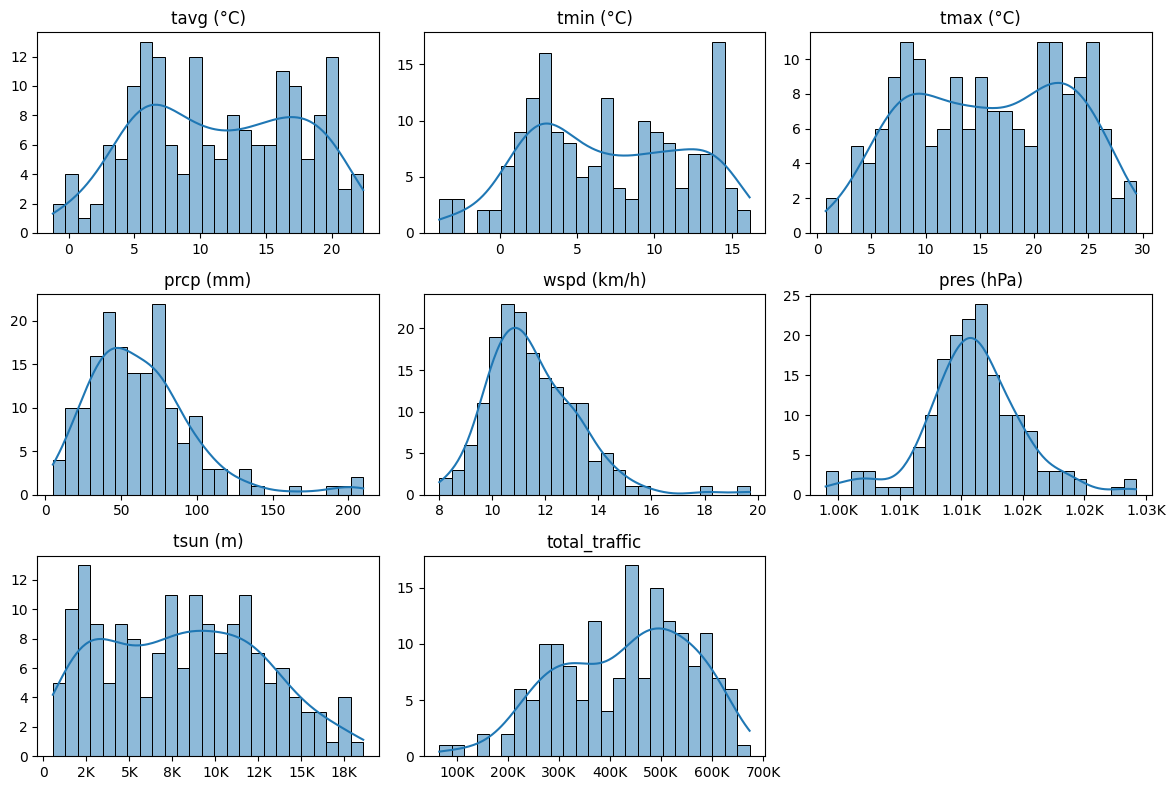

In [60]:
# Plot histograms
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
cols = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres', 'tsun', 'total_traffic']
cols_name = ['tavg (°C)', 'tmin (°C)', 'tmax (°C)', 'prcp (mm)', 'wspd (km/h)', 'pres (hPa)', 'tsun (m)', 'total_traffic']

for i, col in enumerate(cols):
    ax = axes[i//3, i%3]
    sns.histplot(data=final_combined_df, x=col, ax=ax, bins=25, kde=True)
    ax.set_title(cols_name[i])
    ax.set_xlabel('')
    ax.set_ylabel('')

    if col == 'pres':
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K' if x >= 1000 else '{:g}'.format(x)))
    else:
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K' if x >= 1000 else '{:g}'.format(x)))

# Remove empty subplot and hide axis labels
fig.delaxes(axes[2, 2])

plt.tight_layout()
plt.show()